In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
from sklearn.preprocessing import StandardScaler
def read(filepath):
    try:
        df = pd.DataFrame(columns=['number', 'id', 'time_sequence'])
        lines = [line.strip() for line in open(filepath,'r')]
        number = int(lines[1].split(" ")[3])
        id = int(lines[2].split(" ")[3])
        matrix = []
        for i in range(5,len(lines)):
            line = lines[i].split(",")
            line = np.array(line).astype(np.float64)
            matrix.append([ *line[:3]])
        matrix=StandardScaler().fit_transform(matrix)
        
        df.loc[0] = [number, id, matrix]
        return df
    except IOError as e:
        print("Unable to read dataset file!\n")

In [4]:
directory = 'Sketch-Data-master\SketchData\SketchData\Domain01'

df = pd.DataFrame(columns=['number', 'id', 'time_sequence'])
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        df=pd.concat([df,read(f)], ignore_index=True)
        '''le = len(read(f)["time_sequence"].values[0])
        if min > le:
            if le==31:
                print(f)
            min = le'''
# min = 31
#print(df)
#df=preprocess(df)
#print(df)

In [4]:
def cross_validation_split():
    dataset_split = []
    for i in range(10):
        fold=[x for x in range(100*i, 100*(i+1))]
        other=[x for x in range(1000) if x not in fold]
        dataset_split+=[(fold,other)]
    return dataset_split


In [5]:

def DTWdistance(data1,data2, w):
    n=len(data1)
    m=len(data2)
    data2=StandardScaler().fit_transform(data2)

    DTW=np.zeros((n,m))
    w=max(w,abs(n-m))

    for i in range(n):
        for j in range(m):
            DTW[i,j]=np.inf
    DTW[0,0]=0

    for i in range(1,n):
        for j in range(max(1,i-w),min(m,i+w)):
            DTW[i,j]=0
    
    for i in range(1,n):
        for j in range(max(1,i-w),min(m,i+w)):
            cost=distance(data1[i],data2[j])
            DTW[i,j]=cost+np.min([DTW[i-1,j],#insertion
                                DTW[i,j-1],#deletion
                                DTW[i-1,j-1]])#match
    
    return DTW[n-1,m-1]

def distance(a,b):
    return np.linalg.norm(np.absolute(np.array(a)-np.array(b)))

In [23]:
print(DTWdistance(df['time_sequence'][0],df['time_sequence'][1],1000))
print(DTWdistance(df['time_sequence'][1],df['time_sequence'][0],1000))
print(DTWdistance(df['time_sequence'][80],df['time_sequence'][81],100))
print(DTWdistance(df['time_sequence'][81],df['time_sequence'][80],100))
print(DTWdistance(df['time_sequence'][200],df['time_sequence'][281],100))
print(DTWdistance(df['time_sequence'][281],df['time_sequence'][200],100))
print(DTWdistance(df['time_sequence'][800],df['time_sequence'][810],100))
print(DTWdistance(df['time_sequence'][810],df['time_sequence'][800],100))
print(DTWdistance(df['time_sequence'][80],df['time_sequence'][810],100))
print(DTWdistance(df['time_sequence'][810],df['time_sequence'][80],100))

76.88554427518726
76.88554427518713
75.83859355552445
75.83859355552444
96.37773633895833
96.37773633895824
57.3736239673831
57.37362396738302
105.0731593997095
105.07315939970923


In [24]:
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = DTWdistance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

In [25]:
def dist_matrix(x):
    dist_m = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(i+1,x.shape[0]):
            dist_m[i,j]=DTWdistance(x[i],x[j],100)
            dist_m[j,i]=dist_m[i,j]
        if i%50==0:
            print(i/10, "%")
    return dist_m



In [11]:
#X = df["time_sequence"].array
#X=dist_matrix(X)
#np.savetxt("dist_matrix2.csv",X,delimiter=",")
#print(X)
X=np.genfromtxt("dist_matrix2.csv",delimiter=",")
for i in range(len(X)):
    for j in range(len(X[i])):
        if(X[i,j]==np.inf):
            X[i,j]=99999999
y = np.array(df["number"].array,dtype=float)

Average accuracy KNN = 0.925
Standard Deviation KNN = 0.07017834423809098
Median KNN = 0.945
[0.87, 0.99, 1.0, 0.93, 0.79, 0.82, 0.94, 0.97, 0.95, 0.99]


'h = 0.02  # step size in the mesh\n\n# Create color maps\ncmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])\ncmap_bold = ["darkorange", "c", "darkblue"]\n\nfor weights in [DTWdistance]:\n    # we create an instance of Neighbours Classifier and fit the data.\n    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric=DTWdistance)\n    clf.fit(X, y)\n\n    # Plot the decision boundary. For that, we will assign a color to each\n    # point in the mesh [x_min, x_max]x[y_min, y_max].\n    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1\n    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))\n    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])\n\n    # Put the result into a color plot\n    Z = Z.reshape(xx.shape)\n    plt.figure(figsize=(8, 6))\n    plt.contourf(xx, yy, Z) #cmap=cmap_light)\n\n    # Plot also the training points\n    sns.scatterplot(\n        x=X[:, 0],\n

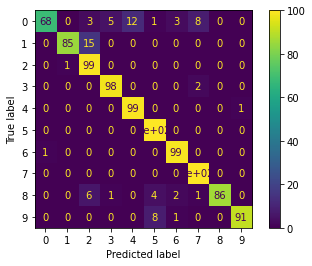

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

n_neighbors = 5

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset

scores_KNN=[]
scores_SVC=[]
conf_matrix=np.zeros((10,10))
for test_ind, train_ind in cross_validation_split():
    x_train, y_train = X[train_ind], y[train_ind]
    x_train=x_train[:,train_ind]
    x_test, y_test = X[test_ind], y[test_ind]
    x_test=x_test[:,train_ind]
    #print(x_train)
    clf = neighbors.KNeighborsClassifier(n_neighbors, metric="precomputed")
    clf.fit(x_train, y_train)
    scores_KNN+=[clf.score(x_test,y_test)]
    conf_matrix+=confusion_matrix(y_test,clf.predict(x_test))
    #sv=SVC(kernel='precomputed',C=1000, gamma='auto')
    #sv.fit(x_train,y_train)
    #scores_SVC+=[sv.score(x_test,y_test)]

print("Average accuracy KNN = "+str(np.mean(scores_KNN)))
print("Standard Deviation KNN = "+str(np.std(scores_KNN)))
print("Median KNN = "+str(np.median(scores_KNN)))
print(scores_KNN)
disp=ConfusionMatrixDisplay(conf_matrix)
disp.plot()

#print("Average accuracy SVC = "+str(np.mean(scores_SVC)))
#print("Standard Deviation SVC = "+str(np.std(scores_SVC)))
#print(scores_SVC)


'''h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in [DTWdistance]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric=DTWdistance)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z) #cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        #hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()'''

## Dollar Recognizer

In [1]:
from DollarRecognizer import Recognizer, Template, Point

In [29]:
tmpl_1 = Template('1',df['time_sequence'][100])
tmpl_2 = Template('2',df['time_sequence'][110])
tmpl_3 = Template('3',df['time_sequence'][120])
recognizer = Recognizer([tmpl_1, tmpl_2, tmpl_3])
result = recognizer.recognize(df['time_sequence'][0])
print(result)
result = recognizer.recognize(df['time_sequence'][100])
print(result)
result = recognizer.recognize(df['time_sequence'][200])
print(result)
result = recognizer.recognize(df['time_sequence'][300])
print(result)
result = recognizer.recognize(df['time_sequence'][400])
print(result)
result = recognizer.recognize(df['time_sequence'][500])
print(result)
result = recognizer.recognize(df['time_sequence'][600])
print(result)
result = recognizer.recognize(df['time_sequence'][10])
print(result)
result = recognizer.recognize(df['time_sequence'][110])
print(result)
result = recognizer.recognize(df['time_sequence'][210])
print(result)
result = recognizer.recognize(df['time_sequence'][310])
print(result)
result = recognizer.recognize(df['time_sequence'][410])
print(result)
result = recognizer.recognize(df['time_sequence'][510])
print(result)
result = recognizer.recognize(df['time_sequence'][610])
print(result)

('1', 0.999447865760563)
('1', 0.9995776487982521)
('1', 0.9995540719582829)
('2', 0.6953319835016216)
('2', 0.7628727299414839)
('2', 0.5367311570106308)
('2', 0.5527146920206677)
('2', 0.999431538273174)
('2', 0.9995399447009371)
('2', 0.999612342495246)
('2', 0.9995069866386862)
('2', 0.9995299024321598)
('2', 0.9995761066186677)
('2', 0.9996252295133263)
